In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import odl
from odl.contrib import torch as odl_torch
# from Get_Ray_Trafo import get_ray_trafo
from ray_transforms import get_ray_trafo
from util import hide_axis,Timer
from data_set_functions_swaped import get_initial_dataset,append_dataset,get_adj_dataset,get_xis,get_x0s,defs_multiple_RTs, defs_list ,error_for_y
from test_model_functions_swaped import get_net_corected_operator
from scipy import sparse
from util import get_op,sparse_Mat,plots


c:\Users\Student\miniconda3\envs\PyTorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
def im_norm(x):
    if type(x) is odl.discr.discr_space.DiscretizedSpaceElement:
        x= x.asarray()
    x = x.reshape(x.size)
    return np.linalg.norm(x,2)
# Training    
pps = 64
x_res = pps
y_res = pps
n_ang = 256
n_dtp = 96#248
impl = 'astra_cpu'
static_ray_trafo = get_ray_trafo(x_res,y_res,n_ang,n_dtp,detector_len=2,impl=impl)


R = odl.solvers.Huber(static_ray_trafo.domain,0.000001)
grad_R = lambda x: x#R.gradient
shift_params =  (np.array([[[0.03,5000,0],[0.03,5000,0]]]))#np.load("shift_params/strong_u_v_shift.npy")#
# grad_R = odl.solvers.L2Norm(static_ray_trafo.domain).gradient
def get_shift(shift_params):
    def shift(angle):
        for i in range(shift_params.shape[0]):
            u_shift = shift_params[i,0,0]*np.sin(shift_params[i,0,1]*angle+shift_params[i,0,2])
            v_shift = shift_params[i,1,0]*np.sin(shift_params[i,1,1]*angle+shift_params[i,1,2])
        return np.array([u_shift,v_shift]).T
    return shift
def rand_shift(angle):
    u_shift = 0*angle+0.1*(np.random.rand()-0.5)
    v_shift = 0*angle+0.1*(np.random.rand()-0.5)

shift = get_shift(shift_params)
ray_trafo = get_ray_trafo(x_res,y_res,n_ang,n_dtp,DET_SHIFT = shift,detector_len=2,impl=impl)
# ray_trafo = get_ray_trafo(x_res,y_res,n_ang,n_dtp,shift_params=shift_params,detector_len=2,impl=impl)

# A_s = sparse_Mat(ray_trafo,x_res,y_res,n_ang,n_dtp)
A_s = sparse.load_npz('Matritzen/64_64_256_96_1_u_and_v_shift/u_v_ray_trafo_0.npz')
true_op = get_op(A_s,x_res,y_res,n_ang,n_dtp)
ray_trafos=[true_op]

A_static_s=sparse.load_npz('Matritzen/64_64_256_96_static.npz')
# A_static_s = sparse_Mat(static_ray_trafo,x_res,y_res,n_ang,n_dtp)
static_op = get_op(A_static_s,x_res,y_res,n_ang,n_dtp)


In [ ]:

op_norm2 = np.linalg.norm(A_static_s.todense(),2)**-2

# true_op = ray_trafo
# ray_trafos=[ray_trafo]
# static_op = static_ray_trafo
# op_norm2 = ray_trafo.norm('estimate')**2

In [48]:
shift_params

array([[[  3.00000000e-02,   5.00000000e+03,   0.00000000e+00],
        [  3.00000000e-02,   5.00000000e+03,   0.00000000e+00]]])

In [49]:
# sparse.save_npz('64_64_256_96_2_u_v_shift.npz',A_s)
# sparse.save_npz('64_64_256_96_static.npz',A_static_s)

In [58]:
lam = 0.0001
mu = 0.0001
num_phant = 1
num_phant_rand = 0
e_p = 0.01
val_defs = defs_list()
tp = np.load('phantoms/'+f'test_phantoms_{pps}_1.npy')
# defs_multiple_RTs(val_defs, np.load('phantoms/'+f'validation_phantoms_{pps}_10.npy'), ray_trafos,
#                   static_op, mu , lam, grad_R,num_phant,num_phant_rand,e_p = e_p, x_0 = None ) #,x_0=np.zeros((pps,pps))

defs_multiple_RTs(val_defs,tp, ray_trafos,
                  static_op, mu , lam, grad_R,num_phant,num_phant_rand,e_p = e_p, x_0 = None ) #,x_0=np.zeros((pps,pps))


num_iterations = 20
# device = 'cuda'
# adj_swaped = True
# fw_swaped = True

In [69]:
class ISTA_Huber():
    def __init__(self,mu,lam,y,fw_op,adj_op,grad_R):
        self.mu = mu
        self.lam = lam
        self.y = y
        self.fw_op = fw_op
        self.adj_op = adj_op
        self.grad_R = grad_R
    
    def soft_shrink(self,x,alpha): 
        return np.sign(x) * np.maximum(np.abs(x)-alpha,0)

    def get_impl(self,x):
        r = self.fw_op(x) - self.y
        F_abl = self.adj_op(r)
        F_abl = F_abl + self.grad_R(x)
        if type(F_abl) is not np.ndarray:
            F_abl = F_abl.asarray()
        x = np.maximum(x-self.mu/self.lam * F_abl, 0)
        # x = np.maximum(x,0)
        return x

In [89]:
lookup = val_defs.lookup
x0_id = lookup.index('x_0')
ye_id = lookup.index('y_e')
mu_id = lookup.index('mu')
lam_id = lookup.index('lambda')
p_idx = lookup.index('phantom')

d = val_defs[0]
p = d[p_idx]
x_0 = d[x0_id] # error_for_y(p,0.1)
y_e = d[ye_id]
mu = 0.00004#0.0001#d[mu_id]
lam = 0.1#0.001 #d[lam_id]
x = x_0
op = true_op



lam = lam#/op_norm2
mu = min(mu,op_norm2)
ISTA_step = ISTA_Huber(mu,lam,y_e,op,op.adjoint,grad_R).get_impl
ISTA_static_step = ISTA_Huber(mu,lam,y_e,static_op,static_op.adjoint,grad_R).get_impl
x_odl = x_0

In [90]:
mu,lam

(4e-05, 0.1)

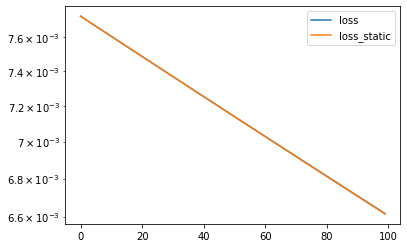

In [91]:
x = x_0
x_static = x_0
loss = list()
loss_static = list()
num_iter = 100
for i in range(num_iter):
    x_old = x
    x = ISTA_step(x)
    x_static = ISTA_static_step(x_static)
    loss.append(np.linalg.norm((x-p).reshape(p.size))/p.size)
    loss_static.append(np.linalg.norm((x_static-p).reshape(p.size))/p.size)
    # fig,ax =plt.subplots()
    # ax.imshow(x)
    # plt.show(fig)
    if im_norm(x-x_old)<1000**-4:
        break

fig,ax =plt.subplots()
ax.plot(loss)
ax.plot(loss_static)
ax.legend(['loss','loss_static'])
ax.set_yscale('log')
plt.show(fig)

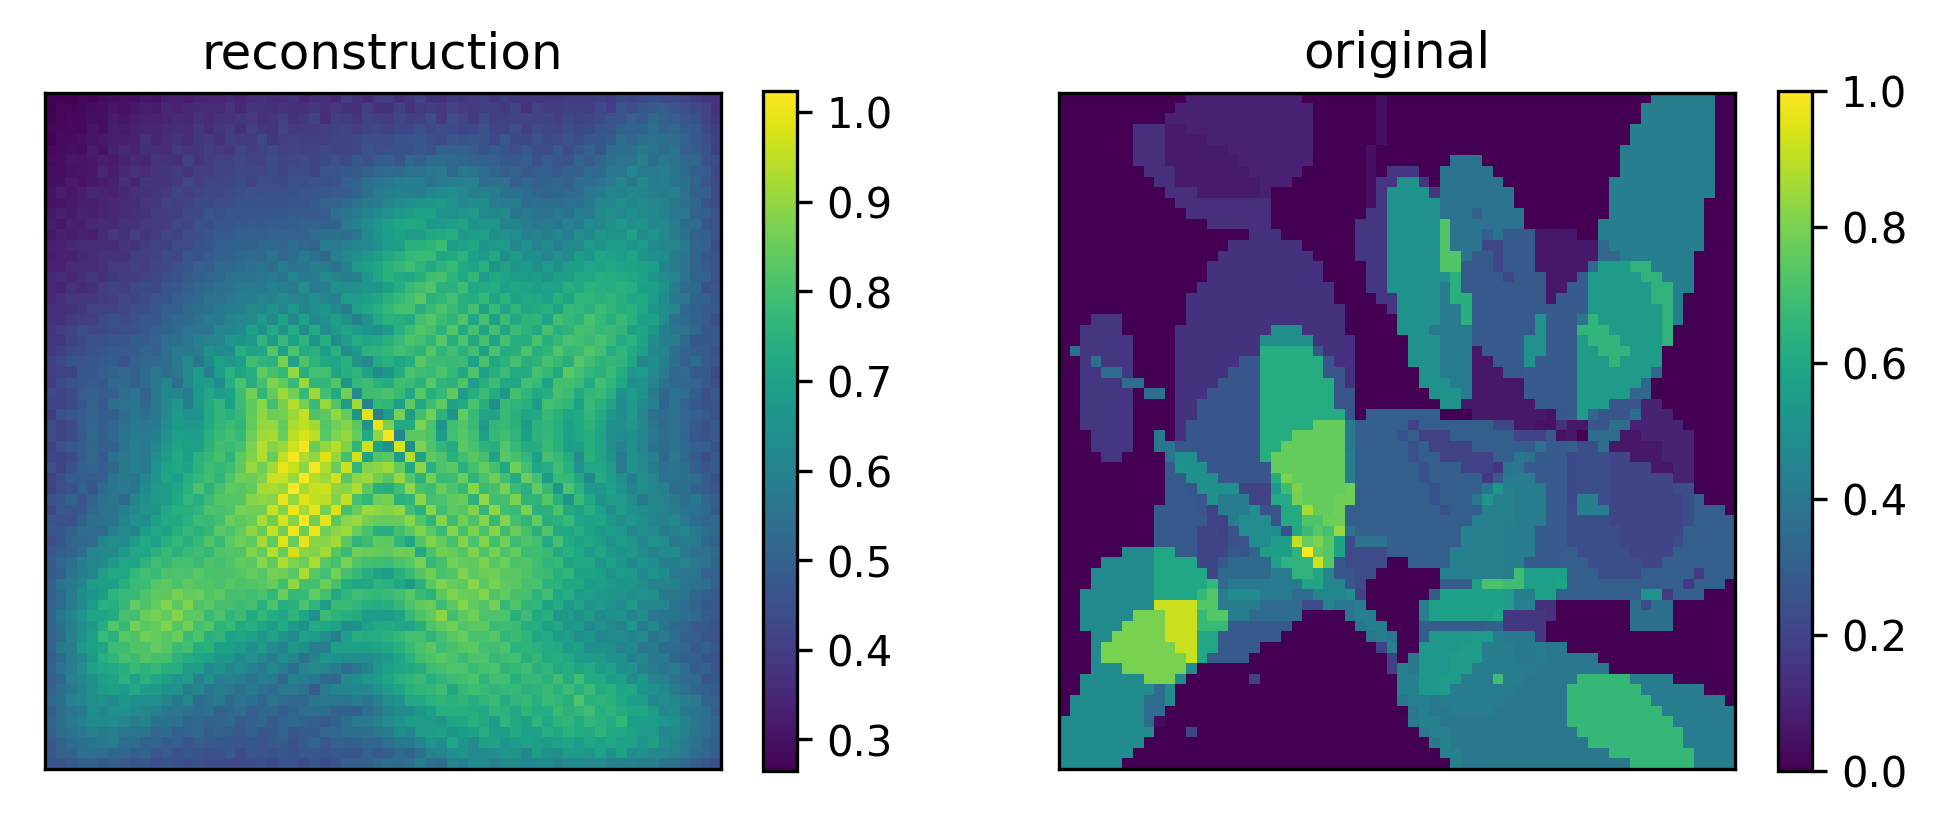

In [92]:
fig,ax = plots(1,2,4/3)
im0 = ax[0].imshow(x)

ax[0].set_title('reconstruction')
im1 = ax[1].imshow(p)  
ax[1].set_title('original')
fig.set_label = f'{num_iter} iterations,mu:{mu} lam:{lam}' 
hide_axis(fig)
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
fig.set_dpi(300)
plt.show(fig)

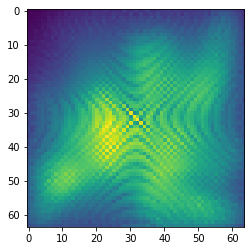

In [88]:
plt.imshow(x_static)

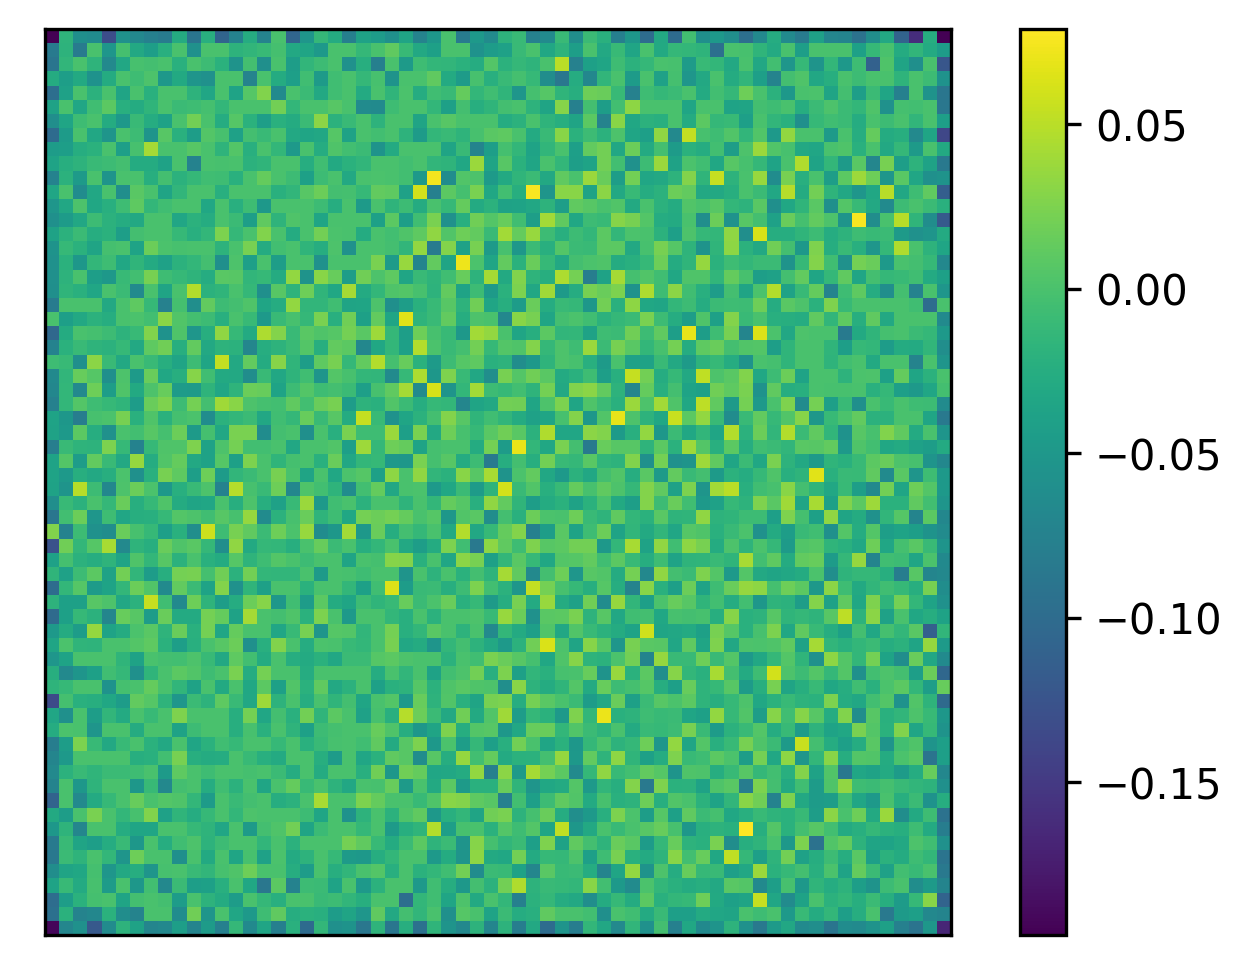

In [22]:
fig,ax = plt.subplots()
im = ax.imshow(p-x)          

hide_axis(fig)
fig.colorbar(im, ax=ax)

fig.set_dpi(300)
plt.show(fig)

In [74]:
op_norm2

0.49173115749737584

In [17]:
np.linalg.norm(A_static_s.todense(),2)**2

0.71338194893457396

In [47]:
from tqdm import tqdm

In [33]:
lookup = val_defs.lookup
x0_id = lookup.index('x_0')
ye_id = lookup.index('y_e')
mu_id = lookup.index('mu')
lam_id = lookup.index('lambda')
p_idx = lookup.index('phantom')

d = val_defs[0]
p = d[p_idx]
x_0 = d[x0_id]
y_e = d[ye_id]
tracker = [np.inf,0,0]
op = static_op
num_iter = 500
j = 0
num_points = 20
loss_mat = np.zeros((num_points,num_points))
for mu in np.logspace(-3,-5,num_points):
        
        k = 0
        for lam in np.logspace(-2,-4,num_points):
                
                x = x_0
                lam = lam*op_norm2
                ISTA_step = ISTA(mu,lam,y_e,op,op.adjoint).get_impl
                for i in range(num_iter):
                        x = ISTA_step(x)
                loss = (np.linalg.norm((x-p).reshape(p.size))/p.size)
                loss_mat[j,k] = loss
                k = k+1
                if tracker[0]>loss:
                        tracker = [loss,mu,lam]
                        print(f'{100*j/num_points:0}% | {tracker}',end="\r")
        j = j+1
        print(f'{100*j/num_points:0}% | {tracker}',end="\r")


                

C:\Users\Student\AppData\Local\Temp\ipykernel_19736\441151023.py:17: RuntimeWarning: overflow encountered in multiply
  x = self.soft_shrink(x-self.mu/self.lam * F_abl, self.mu)
C:\Users\Student\AppData\Local\Temp\ipykernel_19736\441151023.py:17: RuntimeWarning: invalid value encountered in subtract
  x = self.soft_shrink(x-self.mu/self.lam * F_abl, self.mu)


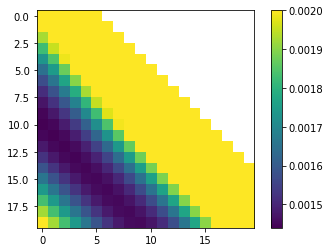

In [36]:
plt.imshow(loss_mat,vmax=0.002)
plt.colorbar()

In [16]:
x_0

array([[ 487.77693401,  494.97819073,  512.89875978, ...,
         535.31119088,  526.75478531,  518.15399529],
       [ 492.96139648,  502.42405156,  515.2539221 , ...,
         543.13506367,  541.68054218,  513.83128883],
       [ 501.30701258,  511.48428286,  518.94019334, ...,
         549.72330795,  549.64712051,  539.40947852],
       ..., 
       [ 501.11910612,  501.1277562 ,  496.18133466, ...,
         569.73222091,  565.96376273,  550.16646504],
       [ 476.34609201,  487.2037154 ,  493.69253853, ...,
         570.56507513,  557.88164972,  539.77550992],
       [ 478.63917669,  482.12095567,  485.22623233, ...,
         560.71505687,  544.626645  ,  532.07724297]])

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(x,vmin=0,vmax=1)
im = ax[1].imshow(p,vmin=0,vmax=1)          

hide_axis(fig)
fig.colorbar(im, ax=ax)
fig.set_dpi(300)
plt.show(fig)

In [6]:
np.logspace(-5,-1,50)

array([  1.00000000e-05,   1.20679264e-05,   1.45634848e-05,
         1.75751062e-05,   2.12095089e-05,   2.55954792e-05,
         3.08884360e-05,   3.72759372e-05,   4.49843267e-05,
         5.42867544e-05,   6.55128557e-05,   7.90604321e-05,
         9.54095476e-05,   1.15139540e-04,   1.38949549e-04,
         1.67683294e-04,   2.02358965e-04,   2.44205309e-04,
         2.94705170e-04,   3.55648031e-04,   4.29193426e-04,
         5.17947468e-04,   6.25055193e-04,   7.54312006e-04,
         9.10298178e-04,   1.09854114e-03,   1.32571137e-03,
         1.59985872e-03,   1.93069773e-03,   2.32995181e-03,
         2.81176870e-03,   3.39322177e-03,   4.09491506e-03,
         4.94171336e-03,   5.96362332e-03,   7.19685673e-03,
         8.68511374e-03,   1.04811313e-02,   1.26485522e-02,
         1.52641797e-02,   1.84206997e-02,   2.22299648e-02,
         2.68269580e-02,   3.23745754e-02,   3.90693994e-02,
         4.71486636e-02,   5.68986603e-02,   6.86648845e-02,
         8.28642773e-02,

In [257]:
tracker = [0,0,0]
for i in range(100):
    x = ISTA_step(x)

loss = (np.linalg.norm((x-p).reshape(p.size))/p.size)
if tracker[0]>=loss:
    tracker = [loss,mu,lam]

In [53]:
[l,mu,lam] = tracker
x = x_0
lam = lam/op_norm
ISTA_step = ISTA(mu,lam,op,y_e,device,model,fw_swaped,adjoint_model,adj_swaped).get_impl
loss = list()
for i in range(10000):
    x = ISTA_step(x)
    loss.append(np.linalg.norm((x-p).reshape(p.size))/p.size)


fig,ax =plt.subplots()
ax.plot(loss)

plt.show(fig)

fig,ax = plt.subplots(1,2)
ax[0].imshow(x,vmin=0,vmax=1)
im = ax[1].imshow(p,vmin=0,vmax=1)          
hide_axis(fig)
fig.colorbar(im, ax=ax)
fig.set_dpi(300)
plt.show(fig)


NameError: name 'tracker' is not defined

In [54]:
mu = 0.001
lam = 0.1
x = x_0
lam = lam/op_norm
ISTA_step = ISTA(mu,lam,op,y_e,device,model,fw_swaped,adjoint_model,adj_swaped).get_impl
loss = list()
for i in range(10000):
    x = ISTA_step(x)
    # x = np.maximum(x,0)
    loss.append(np.linalg.norm((x-p).reshape(p.size))/p.size)


fig,ax =plt.subplots()
ax.plot(loss)
ax.set_yscale('log')
plt.show(fig)

fig,ax = plt.subplots(1,2)
ax[0].imshow(x,vmin=0,vmax=1)
im = ax[1].imshow(p,vmin=0,vmax=1)          

hide_axis(fig)
fig.colorbar(im, ax=ax)
fig.set_dpi(300)
plt.show(fig)

NameError: name 'op_norm' is not defined

In [270]:
np.inf>1

True

In [281]:
from tqdm.auto import tqdm

In [294]:
lookup = val_defs.lookup
x0_id = lookup.index('x_0')
ye_id = lookup.index('y_e')
mu_id = lookup.index('mu')
lam_id = lookup.index('lambda')
p_idx = lookup.index('phantom')

d = val_defs[0]
p = d[p_idx]
x_0 = d[x0_id]
y_e = d[ye_id]
tracker = [np.inf,0,0,np.array((64,64))]
op = ray_trafo
op_norm=op.norm('estimate')
for mu in tqdm(np.logspace(-1,-3,30)):
        for lam in np.logspace(0,-2,30):
                x = x_0
                lam_n = lam/op_norm
                ISTA_step = ISTA(mu,lam_n,op,y_e,device,model,fw_swaped,adjoint_model,adj_swaped).get_impl
                for i in range(100):
                        x = ISTA_step(x)
                        loss = (np.linalg.norm((x-p).reshape(p.size))/p.size)
                        if tracker[0]>loss:
                                tracker = [loss,mu,lam,x]
                                print(tracker[:3])



  0%|          | 0/50 [00:00<?, ?it/s]

[0.0045308499805468113, 0.10000000000000001, 0.28310862901671913]
[0.004440943611354645, 0.056898660290182958, 0.28310862901671913]
[0.0043974527241938243, 0.056898660290182958, 0.28310862901671913]
[0.0043743385891830359, 0.056898660290182958, 0.28310862901671913]
[0.0043611011558695369, 0.056898660290182958, 0.28310862901671913]
[0.0043530366667634303, 0.056898660290182958, 0.28310862901671913]
[0.0043480520907550517, 0.056898660290182958, 0.28310862901671913]
[0.0043450308116097167, 0.056898660290182958, 0.28310862901671913]
[0.0043429063960342094, 0.056898660290182958, 0.28310862901671913]
[0.0043414712531727531, 0.056898660290182958, 0.28310862901671913]
[0.0043404091901747812, 0.056898660290182958, 0.28310862901671913]
[0.0043396341387124497, 0.056898660290182958, 0.28310862901671913]
[0.0043390938082029581, 0.056898660290182958, 0.28310862901671913]
[0.0043387831326103269, 0.056898660290182958, 0.28310862901671913]
[0.004338467738121402, 0.056898660290182958, 0.28310862901671913

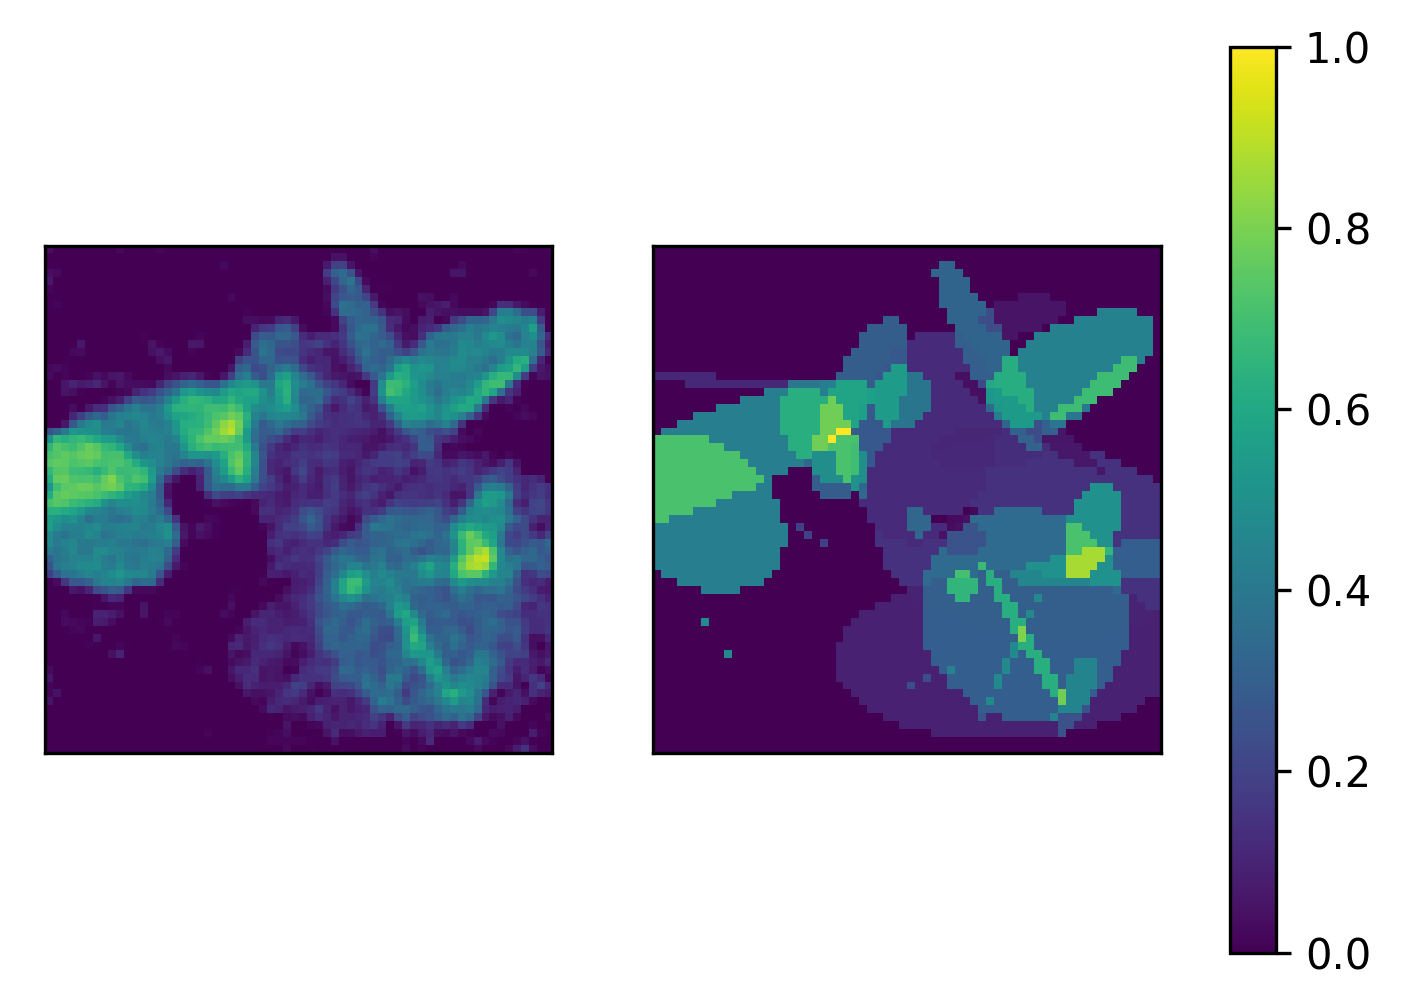

In [296]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(tracker[3],vmin=0,vmax=1)
im = ax[1].imshow(p,vmin=0,vmax=1)          

hide_axis(fig)
fig.colorbar(im, ax=ax)
fig.set_dpi(300)
plt.show(fig)

In [298]:
tracker[:3]

[0.00087439444671250685, 0.032374575428176434, 0.2135522379644833]

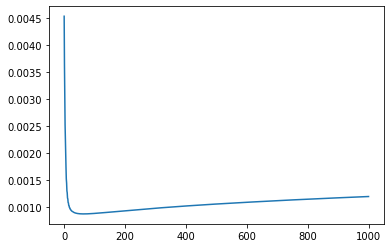

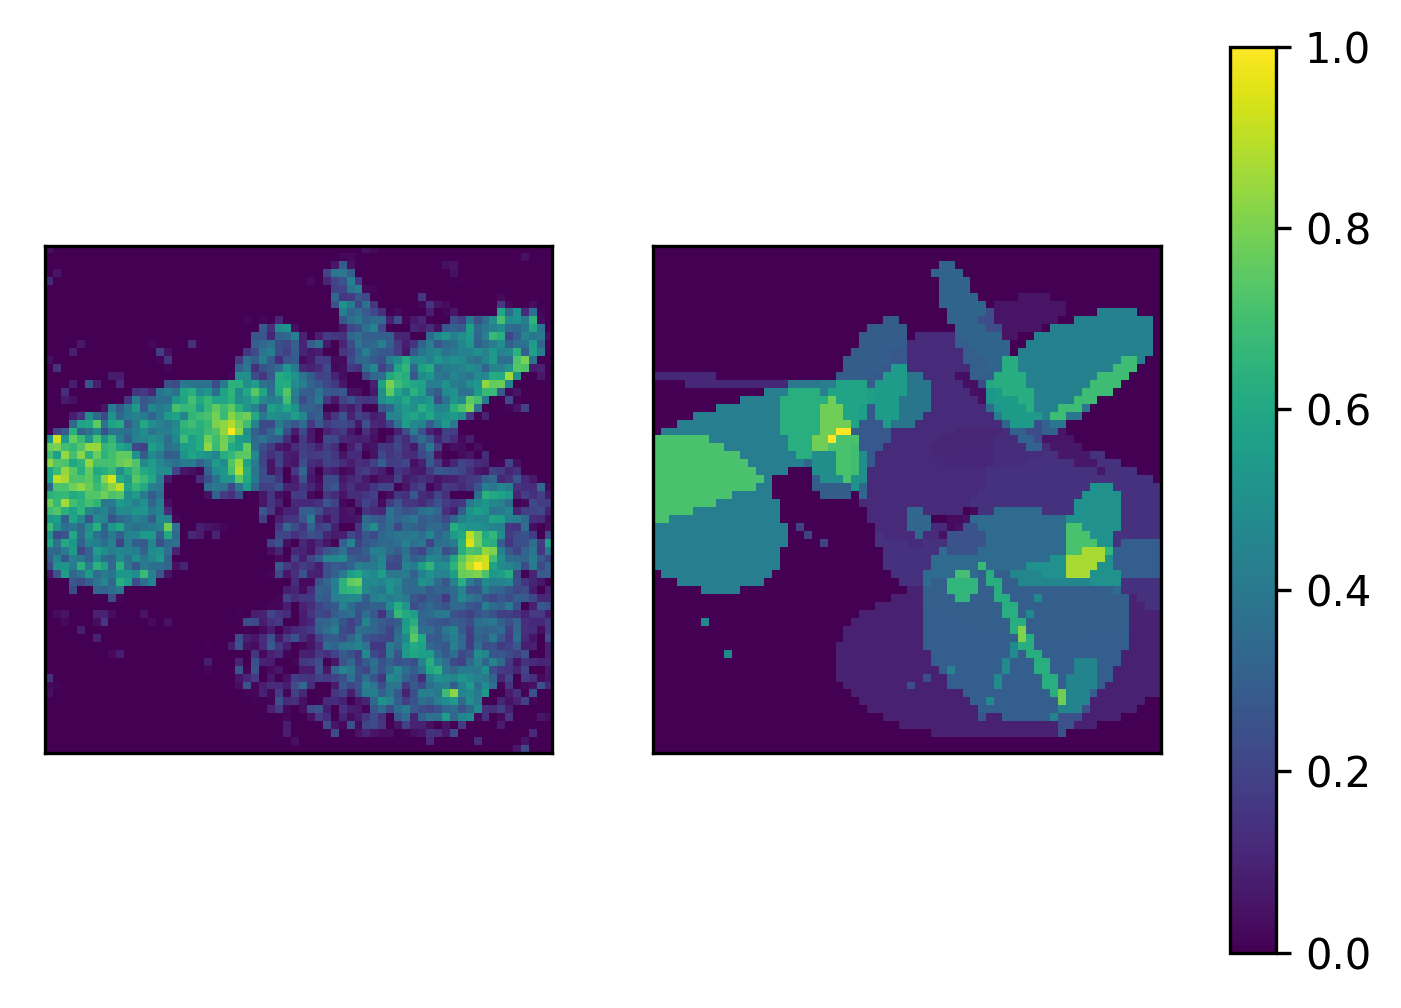

In [307]:
d = val_defs[0]
p = d[p_idx]
x_0 = d[x0_id]
y_e = d[ye_id]
[l,mu,lam] = tracker[:3]
x = x_0
# lam = lam/op_norm
ISTA_step = ISTA(mu,lam,op,y_e,device,model,fw_swaped,adjoint_model,adj_swaped).get_impl
loss = list()
for i in range(1000):
    x = ISTA_step(x)
    loss.append(np.linalg.norm((x-p).reshape(p.size))/p.size)


fig,ax =plt.subplots()
ax.plot(loss)
plt.show(fig)

fig,ax = plt.subplots(1,2)
ax[0].imshow(x,vmin=0,vmax=1)
im = ax[1].imshow(p,vmin=0,vmax=1)          

hide_axis(fig)
fig.colorbar(im, ax=ax)
fig.set_dpi(300)
plt.show(fig)

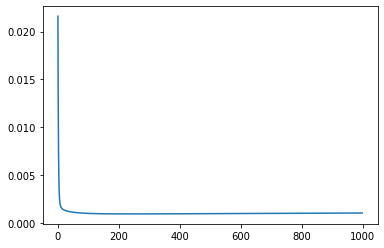

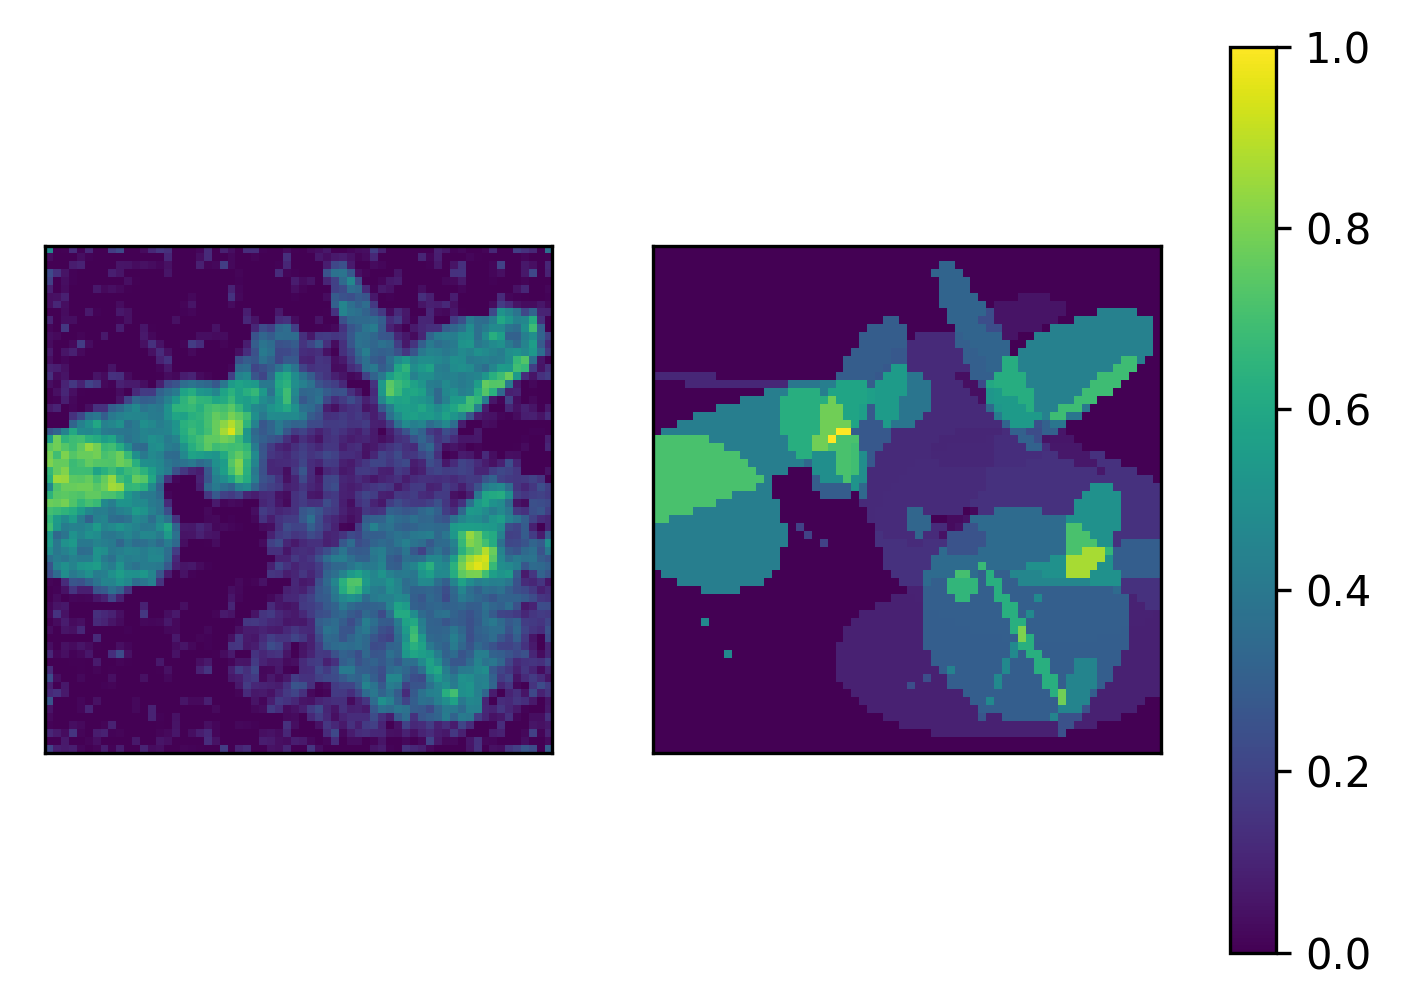

In [308]:
mu = 0.001
lam = 0.1
x = x_0
lam = lam/op_norm
ISTA_step = ISTA(mu,lam,op,y_e,device,model,fw_swaped,adjoint_model,adj_swaped).get_impl
loss = list()
for i in range(1000):
    x = ISTA_step(x)
    # x = np.maximum(x,0)
    loss.append(np.linalg.norm((x-p).reshape(p.size))/p.size)


fig,ax =plt.subplots()
ax.plot(loss)
plt.show(fig)

fig,ax = plt.subplots(1,2)
ax[0].imshow(x,vmin=0,vmax=1)
im = ax[1].imshow(p,vmin=0,vmax=1)          

hide_axis(fig)
fig.colorbar(im, ax=ax)
fig.set_dpi(300)
plt.show(fig)

In [289]:
l

0.0008741340954748774

In [290]:
loss[-1]

0.01963100161985986

In [310]:
lookup = val_defs.lookup
x0_id = lookup.index('x_0')
ye_id = lookup.index('y_e')
mu_id = lookup.index('mu')
lam_id = lookup.index('lambda')
p_idx = lookup.index('phantom')

trackers = list()

for d in val_defs:
        p = d[p_idx]
        x_0 = d[x0_id]
        y_e = d[ye_id]
        tracker = [np.inf,0,0,np.array((64,64))]
        op = ray_trafo
        op_norm=op.norm('estimate')
        for mu in tqdm(np.logspace(-1,-3,30)):
                for lam in np.logspace(0,-2,30):
                        l = tracker[0]
                        x = x_0
                        lam_n = lam/op_norm
                        ISTA_step = ISTA(mu,lam_n,op,y_e,device,model,fw_swaped,adjoint_model,adj_swaped).get_impl
                        for i in range(100):
                                x = ISTA_step(x)
                                loss = (np.linalg.norm((x-p).reshape(p.size))/p.size)
                                if tracker[0]>loss:
                                        tracker = [loss,mu,lam,x]
                        if tracker[0]<l:
                                print(tracker[:3])
        trackers.append(tracker)

  0%|          | 0/30 [00:00<?, ?it/s]

[0.0045308499805468113, 0.10000000000000001, 1.0]
[0.0045119941442878161, 0.062101694189156162, 1.0]
[0.0037920418171593722, 0.052983169062837072, 1.0]
[0.00088214326248052489, 0.045203536563602431, 1.0]
[0.0008730939088973025, 0.038566204211634723, 0.85316785241728088]
[0.00087162941898638428, 0.032903445623126679, 0.72789538439831514]


  0%|          | 0/30 [00:00<?, ?it/s]

[0.0045644907356011339, 0.10000000000000001, 1.0]
[0.0040022161773464997, 0.052983169062837072, 1.0]
[0.0010581848529588049, 0.045203536563602431, 1.0]
[0.0010494319311143906, 0.038566204211634723, 0.85316785241728088]
[0.0010493353119727074, 0.032903445623126679, 0.72789538439831514]


  0%|          | 0/30 [00:00<?, ?it/s]

[0.0038783946731374727, 0.10000000000000001, 1.0]
[0.0038387567560014741, 0.062101694189156162, 1.0]
[0.0025880828864715049, 0.052983169062837072, 1.0]
[0.00074852257174870649, 0.045203536563602431, 1.0]
[0.00074723104200676417, 0.038566204211634723, 1.0]
[0.00073177775808206552, 0.038566204211634723, 0.85316785241728088]
[0.0007307207929589907, 0.032903445623126679, 0.85316785241728088]
[0.00072383789438616904, 0.032903445623126679, 0.72789538439831514]
[0.00072336231482690453, 0.02807216203941177, 0.72789538439831514]
[0.00072246469008361224, 0.02807216203941177, 0.62101694189156154]


  0%|          | 0/30 [00:00<?, ?it/s]

[0.0042584194879434108, 0.10000000000000001, 1.0]
[0.0042552510623037609, 0.062101694189156162, 1.0]
[0.0035889169884996686, 0.052983169062837072, 1.0]
[0.0010437513946731658, 0.045203536563602431, 1.0]
[0.0010326766867636485, 0.038566204211634723, 0.85316785241728088]
[0.0010284717068585578, 0.032903445623126679, 0.72789538439831514]


  0%|          | 0/30 [00:00<?, ?it/s]

[0.0044795928255190829, 0.10000000000000001, 1.0]
[0.003798569717220771, 0.052983169062837072, 1.0]
[0.00070354946327438992, 0.045203536563602431, 1.0]
[0.00066623952041232717, 0.038566204211634723, 1.0]
[0.00066620484366566065, 0.032903445623126679, 1.0]
[0.00065972420915219924, 0.032903445623126679, 0.85316785241728088]


  0%|          | 0/30 [00:00<?, ?it/s]

[0.0053919087640881148, 0.10000000000000001, 1.0]
[0.0044941966453593577, 0.052983169062837072, 1.0]
[0.00093142703398786566, 0.045203536563602431, 1.0]
[0.00092950085478702641, 0.038566204211634723, 0.85316785241728088]


  0%|          | 0/30 [00:00<?, ?it/s]

[0.004298653480234998, 0.10000000000000001, 1.0]
[0.0042824091859479324, 0.062101694189156162, 1.0]
[0.0035071783530964897, 0.052983169062837072, 1.0]
[0.00088814342453063003, 0.045203536563602431, 1.0]
[0.00088465077271171727, 0.038566204211634723, 1.0]
[0.0008755126232050434, 0.038566204211634723, 0.85316785241728088]
[0.00087446197253825727, 0.032903445623126679, 0.85316785241728088]
[0.00087039209997941428, 0.032903445623126679, 0.72789538439831514]


  0%|          | 0/30 [00:00<?, ?it/s]

[0.004276045794360383, 0.10000000000000001, 1.0]
[0.0041901433513613978, 0.062101694189156162, 1.0]
[0.0032418262547318998, 0.052983169062837072, 1.0]
[0.00098361720240350455, 0.045203536563602431, 1.0]
[0.00097127159219761593, 0.038566204211634723, 0.85316785241728088]
[0.00096919466690263331, 0.032903445623126679, 0.72789538439831514]


  0%|          | 0/30 [00:00<?, ?it/s]

[0.0051273219128576946, 0.10000000000000001, 1.0]
[0.0049743607630664977, 0.052983169062837072, 1.0]
[0.00104468229377112, 0.045203536563602431, 1.0]
[0.0010229151283370193, 0.038566204211634723, 1.0]
[0.0010222995354835882, 0.032903445623126679, 0.85316785241728088]


  0%|          | 0/30 [00:00<?, ?it/s]

[0.0052283275090438744, 0.10000000000000001, 1.0]
[0.0050975256720592315, 0.052983169062837072, 1.0]
[0.0010056221019817588, 0.045203536563602431, 1.0]
[0.00092423761010599216, 0.038566204211634723, 1.0]


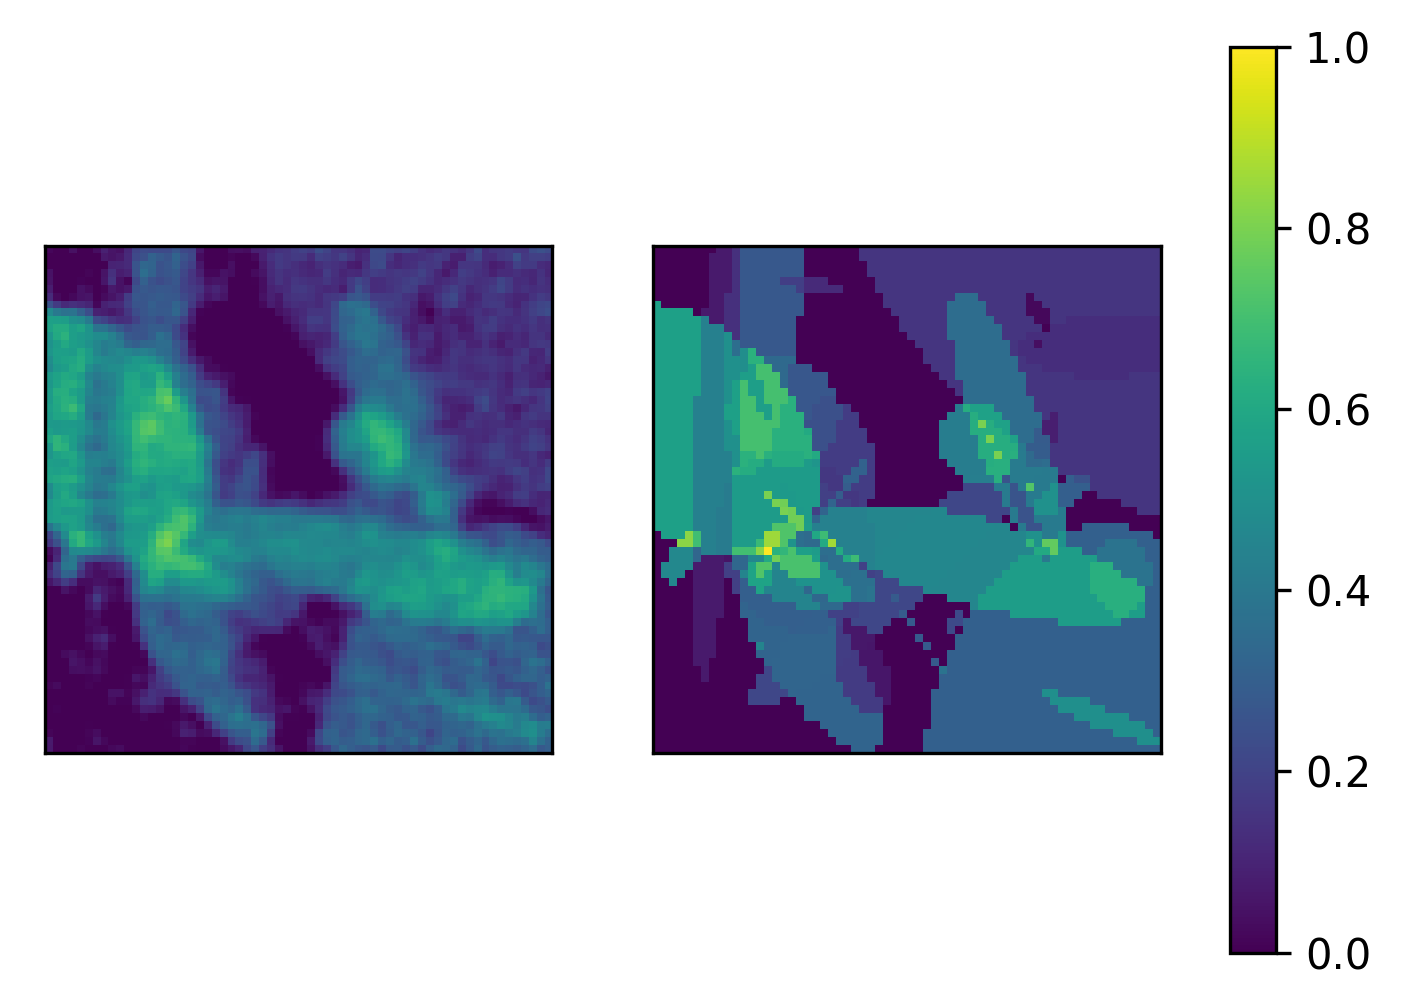

In [311]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(tracker[3],vmin=0,vmax=1)
im = ax[1].imshow(p,vmin=0,vmax=1)          

hide_axis(fig)
fig.colorbar(im, ax=ax)
fig.set_dpi(300)
plt.show(fig)

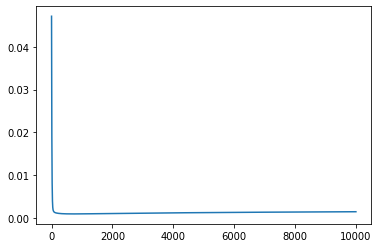

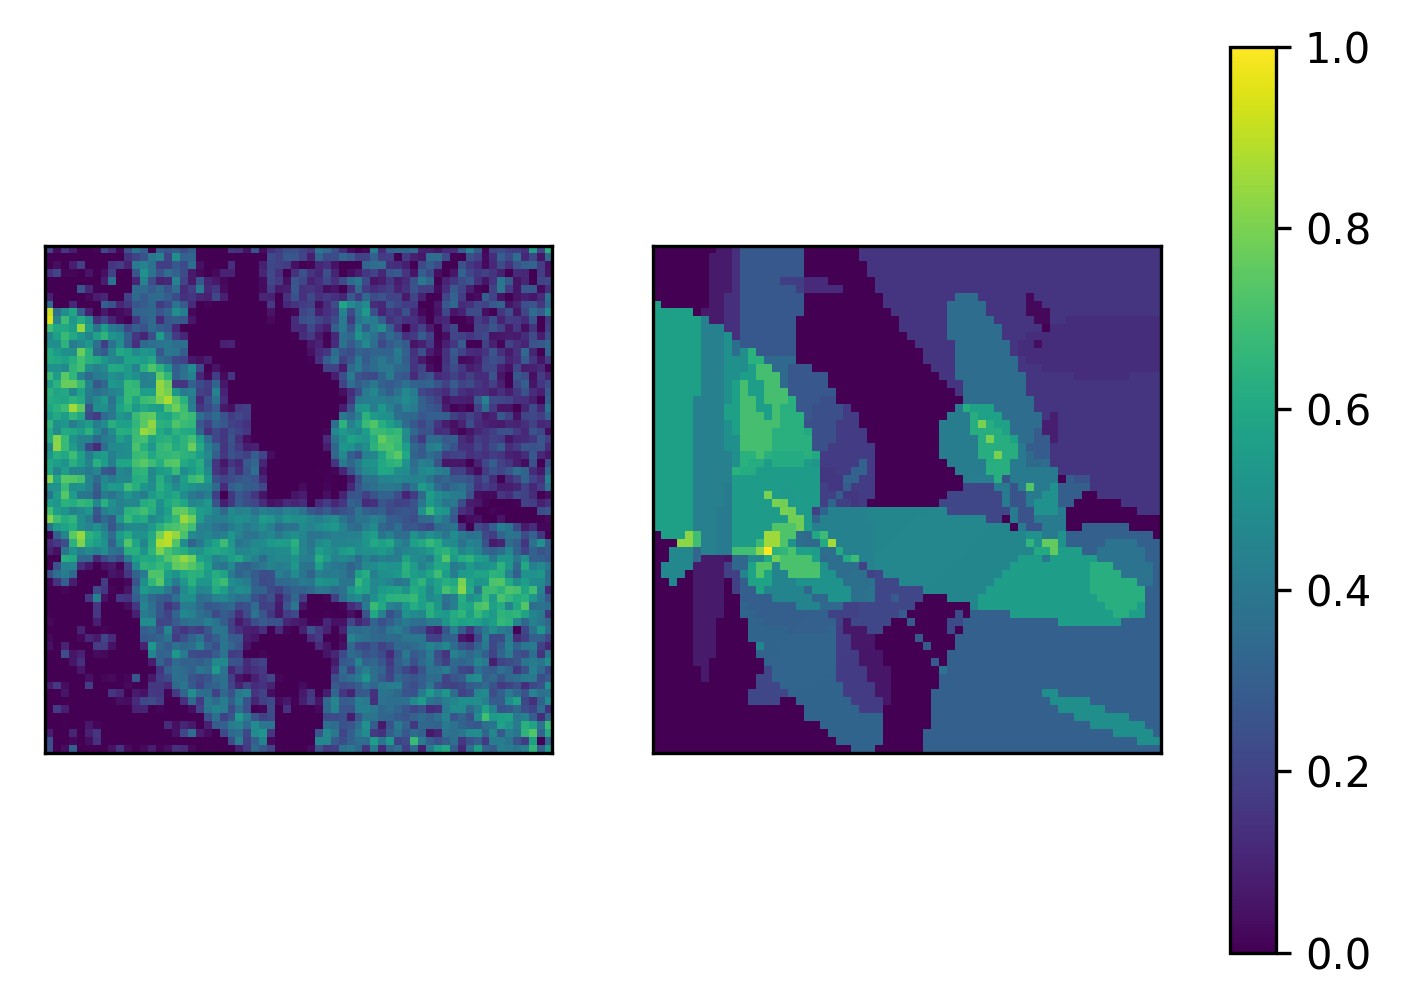

In [314]:
mu = 0.001
lam = 0.5
x = x_0
lam = lam/op_norm
ISTA_step = ISTA(mu,lam,op,y_e,device,model,fw_swaped,adjoint_model,adj_swaped).get_impl
loss = list()
for i in range(10000):
    x = ISTA_step(x)
    # x = np.maximum(x,0)
    loss.append(np.linalg.norm((x-p).reshape(p.size))/p.size)


fig,ax =plt.subplots()
ax.plot(loss)
plt.show(fig)

fig,ax = plt.subplots(1,2)
ax[0].imshow(x,vmin=0,vmax=1)
im = ax[1].imshow(p,vmin=0,vmax=1)          

hide_axis(fig)
fig.colorbar(im, ax=ax)
fig.set_dpi(300)

In [321]:
0.5/op_norm

0.14155420424887968